In [40]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
data = pd.read_csv("../../../Data/Dataset_v2.csv",sep=";")

In [42]:
data.shape

(13666, 24)

### Get features categorie

In [43]:
def categorisation(data,date_cols,target="price"):
    distance = []
    date = []
    numerique = []
    categorique = []
    for col in data.columns:
        if data[col].dtypes == np.object:
            try:
                if str(type(eval(data[col][data[col].first_valid_index()]))) == "<class 'list'>":
                    distance.append(col)
                elif col in date_cols:
                    date.append(col)
                else:
                    categorique.append(col)
            except:
                if col in date_cols:
                    date.append(col)
                else:
                    categorique.append(col)
                
            
        else :
            if col != target:
                numerique.append(col)
                
    return dict({"numerique":numerique,"categorique":categorique,"date":date,"distance":distance})

feat_cat = categorisation(data,["Listing Date"])

### Missing value overview

In [44]:
data.isna().sum()

name                                 0
price                                0
province                             0
city                                 0
address                              0
type_of_property                     0
floor_size                        5729
bathrooms                         1796
pool                             10259
security                          7810
health                            8318
food_and_entertainment            4900
shopping                          8599
sports_and_leisure                6690
levies                            7315
rates_and_taxes                   5012
pets_allowed                      6570
bedrooms                          1497
kitchens                          8646
education                          356
transport_and_public_services     1791
garage                            6461
gardens                          12149
sampling                             0
dtype: int64

### Not use "address" and "name"  because of high cardinality

In [45]:
len(data["address"].unique())

5325

In [46]:
len(data["name"].unique())

7187

In [47]:
data = data.drop(["address","name"],axis=1)

## 1) Categorical feature engineering

In [48]:
feat_cat["categorique"]

['name',
 'province',
 'city',
 'address',
 'type_of_property',
 'pool',
 'security',
 'pets_allowed',
 'garage']

###  "binarisation" (Yes = 1, No = 0) of pool, security and garage where "missing" == 0 (No)

In [49]:
for v in data["pool"].unique():
    if str(v)!="nan":
        if "no" in v or "No" in v or "0" in v or "NO" in v :
            print(v)

Newly gunited 2020
Not Functional
Not in working condition - leaking
Newly renovated pool - full...
Units are on show every Wednesday, Saturday & Sunday from 1:00pm - 5:00pm


In [50]:
for v in data["security"].unique():
    if str(v)!="nan":
        if "no" in v or "No" in v or "0" in v or "NO" in v :
            print(v)

No
Beams not connected 
No alarms
alarm  not activated
Electric fencing - double, except 200 metres bordering to neighbor.


In [51]:
no_garage = []
for v in data["garage"].unique():
    if str(v)!="nan":
        if "0.0" in v or "NO" in v :
            no_garage.append(v)

In [52]:
no_garage

['0.0 Garage(s), No Garage',
 '0.0 Garage(s), Parking in front of building',
 '0.0 Garage(s), Parking',
 '0.0 Garage(s), Plenty open bay parking for 6 or...']

In [53]:
for col in feat_cat["categorique"]:
    if col == "pets_allowed":
        data[col] = data[col].replace(np.nan,"missing")
    elif col == "pool":
        data[col] = data[col].replace(r"Not Functional",np.nan,regex=True)
        data[col] = data[col].replace(r"Not in working condition - leaking",np.nan,regex=True)
        data[col] = data[col].replace(np.nan,"0")
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace(np.nan,1.)
        data[col][data[col]>1.] = 1.
        
    elif col == 'security':
        data[col] = data[col].replace(r"No",np.nan,regex=True)
        data[col] = data[col].replace(r"No alarms",np.nan,regex=True)
        data[col] = data[col].replace(r"alarm  not activated",np.nan,regex=True)
        data[col] = data[col].replace(r"Beams not connected",np.nan,regex=True)
        data[col] = data[col].replace(np.nan,"0")
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace(np.nan,1.)
        data[col][data[col]>1.] = 1.

    elif col == "garage":
        data[col] = data[col].replace(no_garage,np.nan,regex=True)
        data[col] = data[col].replace(np.nan,"0")
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace(np.nan,1.)
        data[col][data[col]>1.] = 1.
    else :
        pass

<ipython-input-53-d4092088be62>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][data[col]>1.] = 1.
<ipython-input-53-d4092088be62>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][data[col]>1.] = 1.
<ipython-input-53-d4092088be62>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][data[col]>1.] = 1.


In [54]:
data["pool"].unique()

array([1., 0.])

In [55]:
data["security"].unique()

array([1., 0.])

In [56]:
data["garage"].unique()

array([0., 1.])

## 2) Numeric Feature engineering 

### Transform distance features to lenght of list

In [57]:
class transfo_distance:
    def __init__(self,data,features=None):
        self.data = data
        self.method = None
        ### Get features
        self.distance=[]
        if features is None:
            for col in data.columns:
                if data[col].dtypes == np.object:
                    try:
                        if str(type(eval(data[col][data[col].first_valid_index()]))) == "<class 'list'>":
                            self.distance.append(col)
                    except:
                        pass
        else:
            distance=features
        
        ###Transformations : "mean", "median", "max", "min", "len"
    def transformation(self,method):
        self.method = method
        for feat in self.distance:
            serie = []
            for i in data[feat]:
                if str(i) != "nan":
                    serie.append(self.checker(i))
                else :
                    serie.append(np.nan)
            self.data[feat] = serie
            
    def checker(self,value):
        if self.method=="mean":
            return (np.array(eval(value))).mean()
        elif self.method =="median":
            return (np.array(eval(value))).mediane()
        elif self.method =="min":
            return (np.array(eval(value))).min()
        elif self.method =="max":
            return (np.array(eval(value))).max()
        elif self.method =="len":
            return float(len(eval(value)))
        else:
            raise('choose correct method : "mean", "median", "max", "min", "len"')
    
    def get_data(self,method="mean"):
        self.transformation(method)
        return self.data

In [58]:
trans_dist = transfo_distance(data)
data = trans_dist.get_data(method="len")
data.shape

(13666, 22)

#### Ampute missing by 0

In [59]:
data[feat_cat["distance"]] = data[feat_cat["distance"]].fillna(0.)

### Check lenght of distances vs price

/home/tokyaxel/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


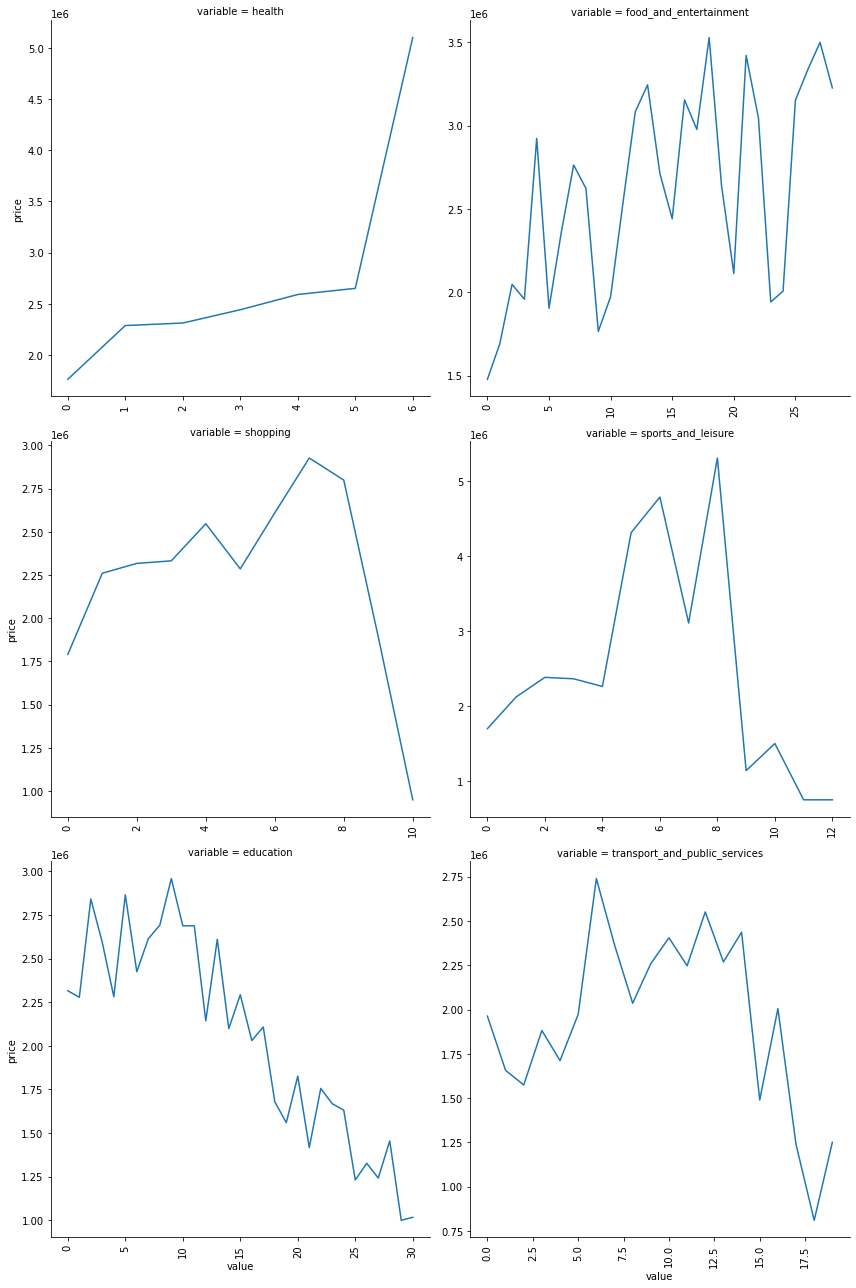

In [60]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
feats = feat_cat["distance"]
f = pd.melt(data, id_vars=['price'], value_vars=feats)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=6)
g = g.map(pairplot, "value", "price")

### Ampute missing by 1 for bedrooms, kitchens, bathrooms (We suppose there are one at least)

In [61]:
data[["bedrooms", "kitchens", "bathrooms"]] = data[["bedrooms", "kitchens", "bathrooms"]].fillna(1.)

### Ampute missing by median for floor size, levies, rates_and_taxes

In [62]:
data[["floor_size", "levies", "rates_and_taxes"]] = data[["floor_size", "levies", "rates_and_taxes"]].fillna(data[["floor_size", "levies", "rates_and_taxes"]].median())

Drop gardens and city (high cardinality)

In [63]:
data = data.drop(["gardens","city"],axis=1)

In [64]:
feat_cat = categorisation(data,["Listing Date"])
feat_cat

{'numerique': ['floor_size',
  'bathrooms',
  'pool',
  'security',
  'health',
  'food_and_entertainment',
  'shopping',
  'sports_and_leisure',
  'levies',
  'rates_and_taxes',
  'bedrooms',
  'kitchens',
  'education',
  'transport_and_public_services',
  'garage',
  'sampling'],
 'categorique': ['province', 'type_of_property', 'pets_allowed'],
 'date': [],
 'distance': []}

### ordinal encoding

In [65]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'price']].groupby(feature).mean()['price']
    #print(frame[[feature, 'a']].groupby(feature).mean()['a'])
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    #print(ordering)
    ordering = ordering['ordering'].to_dict()
    #print(ordering)
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

In [66]:
qual_encoded = []
for q in feat_cat["categorique"]:  
    encode(data, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['province_E', 'type_of_property_E', 'pets_allowed_E']


In [67]:
data.columns

Index(['price', 'province', 'type_of_property', 'floor_size', 'bathrooms',
       'pool', 'security', 'health', 'food_and_entertainment', 'shopping',
       'sports_and_leisure', 'levies', 'rates_and_taxes', 'pets_allowed',
       'bedrooms', 'kitchens', 'education', 'transport_and_public_services',
       'garage', 'sampling', 'province_E', 'type_of_property_E',
       'pets_allowed_E'],
      dtype='object')

In [83]:
feats=['floor_size', 'bathrooms',
       'pool', 'security', 'health', 'food_and_entertainment', 'shopping',
       'sports_and_leisure', 'levies', 'rates_and_taxes',
       'bedrooms', 'kitchens', 'education', 'transport_and_public_services',
       'garage', 'sampling', 'province_E', 'type_of_property_E',
       'pets_allowed_E']

In [84]:
data.shape

(13666, 23)

### Sampling

In [85]:
def split_data(data,target,col="sampling",features_to_keep=None):
    if features_to_keep is not None :
        features_to_keep = features_to_keep + [target]
        data = data[features_to_keep]
        
    unique = data["sampling"].unique()
    for i, v in enumerate(unique):
        if v == 1 :
            data_train = data[data[col]==v]
            y_train = data_train[target]
            X_train = data_train.drop([target,"sampling"],axis=1)
            print("train shape :",X_train.shape)
        elif v == 2 :
            data_val = data[data[col]==v]
            y_val = data_val[target]
            X_val = data_val.drop([target,"sampling"],axis=1)
            print("val shape :",X_val.shape)
        elif v == 3 :
            data_test = data[data[col]==v]
            y_test = data_test[target]
            X_test = data_test.drop([target,"sampling"],axis=1)
            print("test shape :",X_test.shape)
    
            
    return X_train, np.log(y_train), X_val, np.log(y_val), X_test, np.log(y_test)

In [86]:
X_, y_, X_val, y_val, X_test, y_test = split_data(data,"price",features_to_keep=feats)

train shape : (9564, 18)
val shape : (2053, 18)
test shape : (2049, 18)


In [87]:
X_train = X_val.append(X_)
y_train = y_val.append(y_)

# Model : Gradient Boosting
https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

In [88]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [89]:
reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)

GradientBoostingRegressor()

### RMSE on validation set

In [90]:
rmse = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, reg.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

The Root mean squared error (RMSE) on val set: 0.4091
The Root mean squared error (RMSE) on train set: 0.3964


#### feature mportance

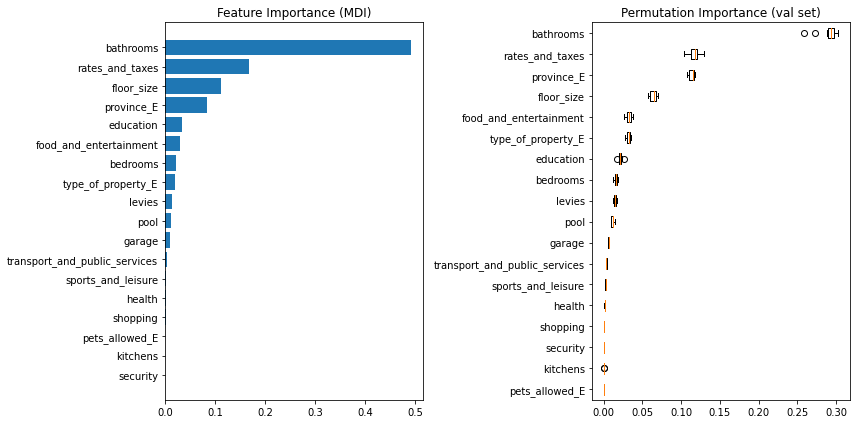

In [91]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_val, y_val, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_train.columns)[sorted_idx])
plt.title("Permutation Importance (val set)")
fig.tight_layout()
plt.show()

In [92]:
print("Model : RF")

RF = RandomForestRegressor()
RF.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_test, RF.predict(X_test)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, RF.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

print("Model : RidgeCV")

regCV = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
regCV.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_test, regCV.predict(X_test)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, regCV.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

print("Model : SVR")

regr = SVR(C=1.0,epsilon=0.2)
regr.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_test, regr.predict(X_test)))
print("The Root mean squared error (RMSE) on val set: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_train, regr.predict(X_train)))
print("The Root mean squared error (RMSE) on train set: {:.4f}".format(rmse))

Model : RF
The Root mean squared error (RMSE) on val set: 0.4082
The Root mean squared error (RMSE) on train set: 0.1632
Model : RidgeCV
The Root mean squared error (RMSE) on val set: 0.4765
The Root mean squared error (RMSE) on train set: 0.4828
Model : SVR
The Root mean squared error (RMSE) on val set: 0.5716
The Root mean squared error (RMSE) on train set: 0.5628
